In [2]:
#PRICING OPCIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import datetime
from scipy.stats import norm
from scipy.optimize import root
from matplotlib.ticker import FormatStrFormatter
from calendar import monthrange
from dateutil.relativedelta import relativedelta

#Definir parámetro spot para definir df de tasas y sup_vol
spot = 3650.0

In [3]:
#DEFINIR FUNCIONES QUE NECESITAMOS

#Función devaluacion - Interpola desde un dataframe que tiene devaluaciones para diferentes plazos
def devaluacion(fecha,df_TASAS):
    #Para determinar en que fila del dataframe está la fecha
    lista_fechas =df_TASAS['Fecha'].to_list()
    idx = pd.Index(lista_fechas)
    posicion= idx.get_loc(fecha, method ='ffill')
    
    #Interpolación lineal de la devaluación según el plazo
    dev = df_TASAS['Devaluacion'].iloc[posicion] + ((df_TASAS['Devaluacion'].iloc[posicion+1] - df_TASAS['Devaluacion'].iloc[posicion]) / (df_TASAS['Fecha'].iloc[posicion+1] - df_TASAS['Fecha'].iloc[posicion]).days) * ((fecha - df_TASAS['Fecha'].iloc[posicion]).days)
    
    return dev

#Función tasa_cop - Interpola desde un dataframe que tiene devaluaciones para diferentes plazos
def tasa_cop(fecha,df_TASAS):
    #Para determinar en que fila del dataframe está la fecha
    lista_fechas =df_TASAS['Fecha'].to_list()
    idx = pd.Index(lista_fechas)
    posicion= idx.get_loc(fecha, method ='ffill')
    
    #Interpolación lineal de la devaluación según el plazo
    i_cop = df_TASAS['Tasa_COP'].iloc[posicion] + ((df_TASAS['Tasa_COP'].iloc[posicion+1] - df_TASAS['Tasa_COP'].iloc[posicion]) / (df_TASAS['Fecha'].iloc[posicion+1] - df_TASAS['Fecha'].iloc[posicion]).days) * ((fecha - df_TASAS['Fecha'].iloc[posicion]).days)
    
    return i_cop

#Función forward - calcula el precio forward a partir del spot, la devaluación y un fecha
def forward(S0,devaluacion,fecha):    
    dias = (fecha-datetime.datetime.now()).days
    forward = S0*(1+devaluacion)**(dias/365)
    
    return forward

#Función BS - calcula el precio de opciones utilizando el modelo de Black. Hace uso del Forward y la tasa local
def VALOR_BS(Fwd, strike, Tasa_Local, volatilidad, fecha, tipo):

#Changing possible integers to float
    Fwd = float(Fwd)
    strike = float(strike)
    Tasa_Local = float(Tasa_Local)    
    volatilidad = float(volatilidad)
    tiempo = (fecha-datetime.datetime.now()).days/365
         
    d1 = (np.log(Fwd/strike) + ((volatilidad)**2 / 2) * tiempo) / (volatilidad * tiempo**(1 / 2))
    d2 = d1 - volatilidad * tiempo**(1/2)         
         
    if tipo == "call":
        nd1 = norm.cdf(d1, )
        nd2 = norm.cdf(d2, )
        VALOR_BS = np.exp(-Tasa_Local * tiempo) * (Fwd * nd1 - strike * nd2)        
         
    elif tipo == "put":
        nd1 = norm.cdf(-d1, )
        nd2 = norm.cdf(-d2, )
        VALOR_BS = np.exp(-Tasa_Local * tiempo) * (strike * nd2 - Fwd * nd1)
        
    return VALOR_BS

#Función imp_strike - calcula el strike implícito dado el delta, el forward, etc
def imp_strike(callput,sigma,dias,delta,forward,tasa_local):      
    if callput == 'call':
        imp_strike = np.exp(-sigma*((dias/365)**0.5)*norm.ppf(delta*np.exp(tasa_local*(dias/365)))+(sigma**2/2)*(dias/365))*forward
    else:
        imp_strike = np.exp(sigma*((dias/365)**0.5)*norm.ppf(delta*np.exp(tasa_local*(dias/365)))+(sigma**2/2)*(dias/365))*forward
    
    return imp_strike


#Función de interpolación de volatilidades en la superficie - Saca una volatilidad para un strike y plazo
def volatility(fecha, strike,df_SUP_VOL):

    #Para determinar en que fila del dataframe está la fecha
    lista_fechas =df_SUP_VOL['Fecha'].to_list()
    idx = pd.Index(lista_fechas)
    posicion= idx.get_loc(fecha, method ='ffill')

    #Para determinar a que columna se acerca más el strike      
    DIF = strike - df_SUP_VOL['Strike_ATM'].iloc[posicion]
    DAF = strike - df_SUP_VOL['Strike_ATM'].iloc[posicion+1]

    if DIF >= 0: #OTM CALL o ITM PUT

        OPCION = 1

        DIF1 = np.abs(DIF)
        DIF2 = np.abs(strike - df_SUP_VOL['Strike_25D_Call'].iloc[posicion])
        DIF3 = np.abs(strike - df_SUP_VOL['Strike_10D_Call'].iloc[posicion])

        DAF1 = np.abs(DAF)
        DAF2 = np.abs(strike - df_SUP_VOL['Strike_25D_Call'].iloc[posicion+1])
        DAF3 = np.abs(strike - df_SUP_VOL['Strike_10D_Call'].iloc[posicion+1])


        if DIF1 < DIF2 :
            Columna11 = 'Volatilidad_ATM'
            Columna12 = 'Volatilidad_25D_CALL'
            Strike11 = 'Strike_ATM'
            Strike12 = 'Strike_25D_Call'
        elif DIF2 < DIF3:
            if strike > df_SUP_VOL['Strike_25D_Call'].iloc[posicion]:
                Columna11 = 'Volatilidad_25D_CALL'
                Columna12 = 'Volatilidad_10D_CALL'
                Strike11 = 'Strike_25D_Call'
                Strike12 = 'Strike_10D_Call'
            else:
                Columna11 = 'Volatilidad_ATM'
                Columna12 = 'Volatilidad_25D_CALL'
                Strike11 = 'Strike_ATM'
                Strike12 = 'Strike_25D_Call'

        else:
            Columna11 = 'Volatilidad_25D_CALL'
            Columna12 = 'Volatilidad_10D_CALL'
            Strike11 = 'Strike_25D_Call'
            Strike12 = 'Strike_10D_Call'


        if strike > df_SUP_VOL['Strike_10D_Call'].iloc[posicion]:
            Dummy1 = 1
        else:
            Dummy1 = 0


        if DAF1 < DAF2:
            Columna21 = 'Volatilidad_ATM'
            Columna22 = 'Volatilidad_25D_CALL'
            Strike21 = 'Strike_ATM'
            Strike22 = 'Strike_25D_Call'
        elif DAF2 < DAF3:
            if strike > df_SUP_VOL['Strike_25D_Call'].iloc[posicion+1]:
                Columna21 = 'Volatilidad_25D_CALL'
                Columna22 = 'Volatilidad_10D_CALL'
                Strike21 = 'Strike_25D_Call'
                Strike22 = 'Strike_10D_Call'
            else:
                Columna21 = 'Volatilidad_ATM'
                Columna22 = 'Volatilidad_25D_CALL'
                Strike21 = 'Strike_ATM'
                Strike22 = 'Strike_25D_Call'            
        else:
            Columna21 = 'Volatilidad_25D_CALL'
            Columna22 = 'Volatilidad_10D_CALL'
            Strike21 = 'Strike_25D_Call'
            Strike22 = 'Strike_10D_Call'


        if strike > df_SUP_VOL['Strike_10D_Call'].iloc[posicion+1]:
            Dummy2 = 1
        else:
            Dummy2 = 0


    elif DIF < 0: #OTM PUT o ITM CALL

        OPCION = 2

        DIF1 = np.abs(DIF)
        DIF2 = np.abs(strike - df_SUP_VOL['Strike_25D_Put'].iloc[posicion])
        DIF3 = np.abs(strike - df_SUP_VOL['Strike_10D_Put'].iloc[posicion])

        DAF1 = np.abs(DAF)
        DAF2 = np.abs(strike - df_SUP_VOL['Strike_25D_Put'].iloc[posicion+1])
        DAF3 = np.abs(strike - df_SUP_VOL['Strike_10D_Put'].iloc[posicion+1])

        if DIF1 < DIF2:
            Columna11 = 'Volatilidad_25D_PUT'
            Columna12 = 'Volatilidad_ATM'
            Strike11 = 'Strike_25D_Put'
            Strike12 = 'Strike_ATM'
        elif DIF2 < DIF3:
            if strike < df_SUP_VOL['Strike_25D_Put'].iloc[posicion]:
                Columna11 = 'Volatilidad_10D_PUT'
                Columna12 = 'Volatilidad_25D_PUT'
                Strike11 = 'Strike_10D_Put'
                Strike12 = 'Strike_25D_Put'
            else:
                Columna11 = 'Volatilidad_25D_PUT'
                Columna12 = 'Volatilidad_ATM'
                Strike11 = 'Strike_25D_Put'
                Strike12 = 'Strike_ATM'         
        else:
            Columna11 = 'Volatilidad_10D_PUT'
            Columna12 = 'Volatilidad_25D_PUT'
            Strike11 = 'Strike_10D_Put'
            Strike12 = 'Strike_25D_Put'


        if strike < df_SUP_VOL['Strike_10D_Put'].iloc[posicion]:
            Dummy1 = 1
        else:
            Dummy1 = 0         

        if DAF1 < DAF2:
            Columna21 = 'Volatilidad_25D_PUT'
            Columna22 = 'Volatilidad_ATM'
            Strike21 = 'Strike_25D_Put'
            Strike22 = 'Strike_ATM'
        elif DAF2 < DAF3:
            if strike < df_SUP_VOL['Strike_25D_Put'].iloc[posicion+1]:
                Columna21 = 'Volatilidad_10D_PUT'
                Columna22 = 'Volatilidad_25D_PUT'
                Strike21 = 'Strike_10D_Put'
                Strike22 = 'Strike_25D_Put'
            else:
                Columna21 = 'Volatilidad_25D_PUT'
                Columna22 = 'Volatilidad_ATM'
                Strike21 = 'Strike_25D_Put'
                Strike22 = 'Strike_ATM'     
        else:
            Columna21 = 'Volatilidad_10D_PUT'
            Columna22 = 'Volatilidad_25D_PUT'
            Strike21 = 'Strike_10D_Put'
            Strike22 = 'Strike_25D_Put'


        if strike < df_SUP_VOL['Strike_10D_Put'].iloc[posicion+1]:
            Dummy2 = 1
        else:
            Dummy2 = 0


    if Dummy1 == 0:
        Vol1 = df_SUP_VOL[Columna11].iloc[posicion]+((df_SUP_VOL[Columna12].iloc[posicion]-df_SUP_VOL[Columna11].iloc[posicion])/(df_SUP_VOL[Strike12].iloc[posicion]-df_SUP_VOL[Strike11].iloc[posicion]))*(strike-df_SUP_VOL[Strike11].iloc[posicion])
    else:
        if OPCION ==1:
            Vol1 = df_SUP_VOL[Columna12].iloc[posicion]
        else:
            Vol1 = df_SUP_VOL[Columna11].iloc[posicion]

    if Dummy2 == 0:
        Vol2 = df_SUP_VOL[Columna21].iloc[posicion+1]+((df_SUP_VOL[Columna22].iloc[posicion+1]-df_SUP_VOL[Columna21].iloc[posicion+1])/(df_SUP_VOL[Strike22].iloc[posicion+1]-df_SUP_VOL[Strike21].iloc[posicion+1]))*(strike-df_SUP_VOL[Strike21].iloc[posicion+1])
    else:
        if OPCION == 1:    
            Vol2 = df_SUP_VOL[Columna22].iloc[posicion+1]
        else:
            Vol2 = df_SUP_VOL[Columna21].iloc[posicion+1]

    Vol = Vol1 + ((Vol2 - Vol1) / (df_SUP_VOL['Fecha'].iloc[posicion+1] - df_SUP_VOL['Fecha'].iloc[posicion]).days) * ((fecha - df_SUP_VOL['Fecha'].iloc[posicion]).days)
    
    return Vol

In [4]:
#CARGAR PARÁMETROS DE TASAS Y SUPERFICIES DE VOLATILIDADES

#Cargar parámetros superficie de volatilidades
df = pd.read_excel (r'C:/Users/andrgome/ALTERNATIVOS/Memo_Vol_Banco.xlsx')
df_SUP_VOL = df[['Memo de Volatilidad','Unnamed: 1','Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5']].iloc[40:51]

#Renombrar columnas
df_SUP_VOL = df_SUP_VOL.rename(columns={'Memo de Volatilidad':'Plazo',
                                        'Unnamed: 1':'Volatilidad_10D_PUT',
                                        'Unnamed: 2':'Volatilidad_25D_PUT',
                                        'Unnamed: 3':'Volatilidad_ATM',
                                        'Unnamed: 4':'Volatilidad_25D_CALL',
                                        'Unnamed: 5': 'Volatilidad_10D_CALL'                                        
                                               })

#Cargar parámetros de devaluaciones y tasas
df_TASAS= df.iloc[[20, 21, 22,23,24,27,30,33,34,35,36,37],:]
df_TASAS = df_TASAS[['Memo de Volatilidad','Unnamed: 1','Unnamed: 2','Unnamed: 3','Unnamed: 4']]

#Renombrar columnas
df_TASAS = df_TASAS.rename(columns={'Memo de Volatilidad':'Plazo',
                                        'Unnamed: 1':'Tasa_USD',
                                        'Unnamed: 2':'Tasa_COP',
                                        'Unnamed: 3':'Devaluacion_BID',
                                        'Unnamed: 4':'Devaluacion_ASK'                                        
                                               })

#Insertar nuevos campos
df_SUP_VOL.insert(1, "Fecha",datetime.datetime(2021,4,28))
df_SUP_VOL.insert(2, "Dias",1)
df_SUP_VOL.insert(3, "Spot",spot)
df_SUP_VOL.insert(4, "Devaluacion",0.01)
df_SUP_VOL.insert(5, "Forward",0.01)
df_SUP_VOL.insert(6, "Tasa_COP",0.01)
df_SUP_VOL.insert(7, "Strike_10D_Put",0.01)
df_SUP_VOL.insert(8, "Strike_25D_Put",0.01)
df_SUP_VOL.insert(9, "Strike_ATM",0.01)
df_SUP_VOL.insert(10, "Strike_25D_Call",0.01)
df_SUP_VOL.insert(11, "Strike_10D_Call",0.01)

#Calcular fechas
df_SUP_VOL['Fecha'].iloc[0] = datetime.datetime.now() + relativedelta(days=1)
df_SUP_VOL['Fecha'].iloc[1] = datetime.datetime.now() + relativedelta(weeks=1)
df_SUP_VOL['Fecha'].iloc[2] = datetime.datetime.now() + relativedelta(months=1)
df_SUP_VOL['Fecha'].iloc[3] = datetime.datetime.now() + relativedelta(months=2)
df_SUP_VOL['Fecha'].iloc[4] = datetime.datetime.now() + relativedelta(months=3)
df_SUP_VOL['Fecha'].iloc[5] = datetime.datetime.now() + relativedelta(months=6)
df_SUP_VOL['Fecha'].iloc[6] = datetime.datetime.now() + relativedelta(months=9)
df_SUP_VOL['Fecha'].iloc[7] = datetime.datetime.now() + relativedelta(months=12)
df_SUP_VOL['Fecha'].iloc[8] = datetime.datetime.now() + relativedelta(months=12*2)
df_SUP_VOL['Fecha'].iloc[9] = datetime.datetime.now() + relativedelta(months=12*3)
df_SUP_VOL['Fecha'].iloc[10] = datetime.datetime.now() + relativedelta(months=12*5)

#Cálculo de días
df_SUP_VOL['Dias'] = df_SUP_VOL['Fecha'].apply(lambda x: (x-datetime.datetime.now()).days)

#Cálculo devaluación mid
for i in range(0,df_SUP_VOL.shape[0]):    
    df_SUP_VOL['Devaluacion'].iloc[i] = (df_TASAS['Devaluacion_BID'].iloc[i]+df_TASAS['Devaluacion_ASK'].iloc[i])/2

#Cálculo forward
for i in range(0,df_SUP_VOL.shape[0]):    
    df_SUP_VOL['Forward'].iloc[i] = df_SUP_VOL['Spot'].iloc[i]*(1+df_SUP_VOL['Devaluacion'].iloc[i])**(df_SUP_VOL['Dias'].iloc[i]/365)

#Cálculo Tasa COP
for i in range(0,df_SUP_VOL.shape[0]):    
    df_SUP_VOL['Tasa_COP'].iloc[i] = df_TASAS['Tasa_COP'].iloc[i]

    
#Cálculo strike implícito
for i in range(0,df_SUP_VOL.shape[0]):    
    df_SUP_VOL['Strike_10D_Put'].iloc[i] = imp_strike('put',df_SUP_VOL['Volatilidad_10D_PUT'].iloc[i],df_SUP_VOL['Dias'].iloc[i],0.1,df_SUP_VOL['Forward'].iloc[i],df_SUP_VOL['Tasa_COP'].iloc[i])
    df_SUP_VOL['Strike_25D_Put'].iloc[i] = imp_strike('put',df_SUP_VOL['Volatilidad_25D_PUT'].iloc[i],df_SUP_VOL['Dias'].iloc[i],0.25,df_SUP_VOL['Forward'].iloc[i],df_SUP_VOL['Tasa_COP'].iloc[i])
    df_SUP_VOL['Strike_ATM'].iloc[i] = df_SUP_VOL['Forward'].iloc[i]
    df_SUP_VOL['Strike_25D_Call'].iloc[i] = imp_strike('call',df_SUP_VOL['Volatilidad_25D_CALL'].iloc[i],df_SUP_VOL['Dias'].iloc[i],0.25,df_SUP_VOL['Forward'].iloc[i],df_SUP_VOL['Tasa_COP'].iloc[i])
    df_SUP_VOL['Strike_10D_Call'].iloc[i] = imp_strike('call',df_SUP_VOL['Volatilidad_10D_CALL'].iloc[i],df_SUP_VOL['Dias'].iloc[i],0.10,df_SUP_VOL['Forward'].iloc[i],df_SUP_VOL['Tasa_COP'].iloc[i])
    
#Insertar nuevos campos
df_TASAS.insert(1, "Fecha",datetime.datetime(2021,4,28))
df_TASAS.insert(2, "Dias",1)
df_TASAS.insert(3, "Devaluacion",1)

#Calcular fechas
df_TASAS['Fecha'].iloc[0] = datetime.datetime.now() + relativedelta(days=1)
df_TASAS['Fecha'].iloc[1] = datetime.datetime.now() + relativedelta(weeks=1)
df_TASAS['Fecha'].iloc[2] = datetime.datetime.now() + relativedelta(months=1)
df_TASAS['Fecha'].iloc[3] = datetime.datetime.now() + relativedelta(months=2)
df_TASAS['Fecha'].iloc[4] = datetime.datetime.now() + relativedelta(months=3)
df_TASAS['Fecha'].iloc[5] = datetime.datetime.now() + relativedelta(months=6)
df_TASAS['Fecha'].iloc[6] = datetime.datetime.now() + relativedelta(months=9)
df_TASAS['Fecha'].iloc[7] = datetime.datetime.now() + relativedelta(months=12)
df_TASAS['Fecha'].iloc[8] = datetime.datetime.now() + relativedelta(months=12*2)
df_TASAS['Fecha'].iloc[9] = datetime.datetime.now() + relativedelta(months=12*3)
df_TASAS['Fecha'].iloc[10] = datetime.datetime.now() + relativedelta(months=12*4)
df_TASAS['Fecha'].iloc[11] = datetime.datetime.now() + relativedelta(months=12*5)

#Cálculo de días
df_TASAS['Dias'] = df_TASAS['Fecha'].apply(lambda x: (x-datetime.datetime.now()).days)

#Cálculo devaluación mid
for i in range(0,df_TASAS.shape[0]):    
    df_TASAS['Devaluacion'].iloc[i] = (df_TASAS['Devaluacion_BID'].iloc[i]+df_TASAS['Devaluacion_ASK'].iloc[i])/2


C:\Users\andrgome\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


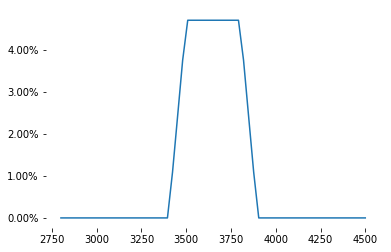

Para un CDT de nominal 1,000 MM hay que vender opciones por 228,706 USD
Sacando 5 pesos en las primas de las opciones se genera una utilidad de 23 pb


In [31]:
#CÁLCULO DE PERFIL DE PAGO DE BUTTERLY O CONDOR VENDIDO CON CDT

rango_spot = np.linspace(2800, 4500, 61)   #Rango en el que vamos a estimar la rentabilidad

fecha = datetime.datetime(2021,4,28)
T = (fecha - datetime.datetime.now()).days/365
K1 = 3800 #Strike call vendida
K2 = 3900 #Strike call comprada - debe ser mayor a K1

#Diccionario con información de las opciones que hacen parte del CONDOR
CONDOR = {"CALL VENDIDA":['call',K1,VALOR_BS(forward(spot,devaluacion(fecha,df_TASAS),fecha), K1, tasa_cop(fecha,df_TASAS), volatility(fecha, K1,df_SUP_VOL), fecha, 'call'),-1],   #Tipo opción, Strike, Prima, 1 compra o -1 venta
            "CALL COMPRADA":['call',K2,VALOR_BS(forward(spot,devaluacion(fecha,df_TASAS),fecha), K2, tasa_cop(fecha,df_TASAS), volatility(fecha, K2,df_SUP_VOL), fecha, 'call'),1],
          "PUT VENDIDA":['put',3500,32,-1],
          "PUT COMPRADA":['put',3400,12,1]
            }        

CDT = {"TUYA":[0.03,180,1000000000,229432]}   #Diccionario con información del CDT. Tasa de interés, días al vcto, nominal, nominal opciones vendidas

UTILIDAD = 5

#Calculamos el PyG de las opciones para los diferentes niveles del spot
lista_PYG = []

for i in range(0,rango_spot.shape[0]):
    item = (np.maximum(rango_spot[i]-CONDOR["CALL VENDIDA"][1],0)-CONDOR["CALL VENDIDA"][2])*CONDOR["CALL VENDIDA"][3] + \
    (np.maximum(rango_spot[i]-CONDOR["CALL COMPRADA"][1],0)-CONDOR["CALL COMPRADA"][2])*CONDOR["CALL COMPRADA"][3] + \
    (np.maximum(CONDOR["PUT VENDIDA"][1]-rango_spot[i],0)-CONDOR["PUT VENDIDA"][2])*CONDOR["PUT VENDIDA"][3] + \
    (np.maximum(CONDOR["PUT COMPRADA"][1]-rango_spot[i],0)-CONDOR["PUT COMPRADA"][2])*CONDOR["PUT COMPRADA"][3]
    lista_PYG.append(item)


#Agregamos el PyG del CDT al PyG de las opciones

lista_PYG = np.dot(lista_PYG,CDT["TUYA"][3]) #Ajustando por nominal de las opciones

#Calculamos la rentabilidad de la nota en los diferentes niveles del spot
Rent_NOTA = [((CDT["TUYA"][2]*(1+CDT["TUYA"][0])**(CDT["TUYA"][1]/365)+ x)/CDT["TUYA"][2])**(365/CDT["TUYA"][1])-1 for x in lista_PYG] #Sumando los rendimientos del CDT


#Con esto podemos determinar cuanto debería ser el nominal para que sea capital protegido
def function1(x):
        return ((np.maximum(CONDOR["CALL COMPRADA"][1]-CONDOR["CALL VENDIDA"][1],CONDOR["PUT VENDIDA"][1]-CONDOR["PUT COMPRADA"][1]))+\
                    CONDOR["CALL VENDIDA"][2]*CONDOR["CALL VENDIDA"][3]+\
                     CONDOR["CALL COMPRADA"][2]*CONDOR["CALL COMPRADA"][3]+\
                    CONDOR["PUT VENDIDA"][2]*CONDOR["PUT VENDIDA"][3]+\
                    CONDOR["PUT COMPRADA"][2]*CONDOR["PUT COMPRADA"][3])*(-x)+\
                    CDT["TUYA"][2]*(1+CDT["TUYA"][0])**(CDT["TUYA"][1]/365)-CDT["TUYA"][2]
    
sol1 = root(function1,CDT["TUYA"][3])
nominal = sol1.x[0]


fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

ax1.plot(rango_spot,np.dot(Rent_NOTA,100))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.2f%%'))
plt.show()


print('Para un CDT de nominal ' + '{:,.0f}'.format(np.round(CDT["TUYA"][2]/1000000,0)) +' MM hay que vender opciones por '+ '{:,.0f}'.format(np.round(nominal,0)) + ' USD')  

print('Sacando '+str(UTILIDAD)+' pesos en las primas de las opciones se genera una utilidad de '+'{:,.0f}'.format(np.round(((1+(CDT["TUYA"][3]*UTILIDAD/CDT["TUYA"][2]))**(365/CDT["TUYA"][1])-1)*10000,0)) + ' pb') #puntos básicos de utilidad en la nota